In [1]:
import os
os.environ.update(
    OMP_NUM_THREADS="1", OPENBLAS_NUM_THREADS="1", NUMEXPR_NUM_THREADS="1", MKL_NUM_THREADS="1"
)

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import arviz as az
import corner

from util import phasefold, get_stats, plot_binned

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Numbers from teh SPOC S1-39 multisector https://tev.mit.edu/data/delivered-signal/i226894/
period = 1.74469
epoch = 1326.9843
ror = 0.0123
duration = 1.1574 / 24 # in days

In [4]:
tic_info = pd.read_csv("data/tic_82.csv", index_col=0).T

In [5]:
lc = pd.read_csv("data/lc.csv", index_col=0)
lc = lc[lc["quality"] == 0]
phase = phasefold(lc["time"], period, epoch)
intran = np.abs(phase) < 2 * duration / period
lc = lc[intran]
print(lc.shape)

(60985, 24)


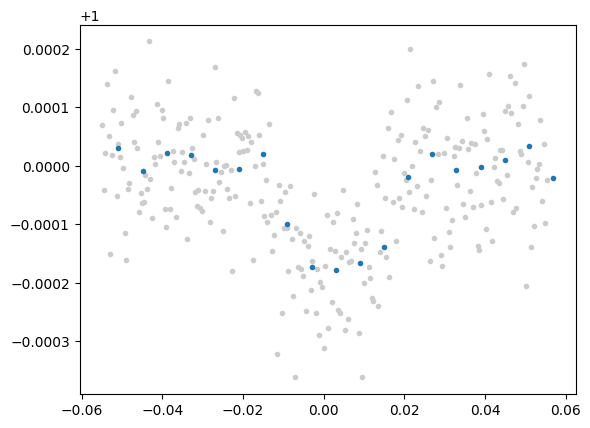

In [6]:
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(1/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(15/60/24)))

In [7]:
with pm.Model() as model:
    t0 = pm.Uniform("t0", lower=epoch - .1 * period, upper = epoch + .1 * period)
    per = pm.Uniform("per", lower=0.9*period, upper=1.1*period)
    
    ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
    ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

    ror = pm.Uniform("ror", lower=0, upper=2, testval=ror)
    b = pm.Uniform("b", lower=-(ror + 1), upper=(ror + 1))
    
    # From Table 1
    m_star = pm.Normal("m_star", mu=0.421, sd=.021)
    r_star = pm.Normal("r_star", mu=0.427, sd=0.021)
    
    orbit = xo.orbits.KeplerianOrbit(
        r_star=r_star,
        m_star=m_star,
        period=per,
        t0=t0,
        b=b,
        ecc=ecc,
        omega=omega
    )
    u = xo.distributions.QuadLimbDark("u")
    lcs = pm.Deterministic(
        "lcs",
        xo.LimbDarkLightCurve(u).get_light_curve(
            orbit=orbit,
            r=ror*r_star,
            t=lc["time"],
            texp=0.00138889, # 2 min
            oversample=3,
        )
    )
    mean = pm.Normal("mean", mu=1.0, sd=0.5)
    full_lc = tt.sum(lcs, axis=-1) + mean
    pm.Deterministic("full_lc", full_lc)
    
    # Observation model
    pm.Normal("obs", mu=full_lc, sd=lc["flux_err"], observed=lc["flux"], shape=len(lc))

In [8]:
# Find MAP parameter solution
# This helps us make sure our model is set up reasonably and
# will give MCMC a starting point
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[mean])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 333367.6471193272 -> 333380.37404206686
optimizing logp for variables: [mean, u, r_star, m_star, b, ror, ecs, per, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 333380.37404206686 -> 333392.7567244951


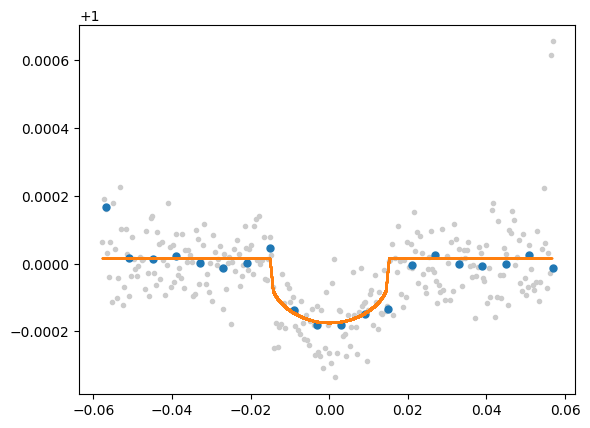

In [9]:
plot_binned(lc["time"], lc["flux"], map_soln["per"], map_soln["t0"], bins=int(period/(1/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], map_soln["per"], map_soln["t0"], bins=int(period/(15/60/24)), s=100)
plot_binned(lc["time"], map_soln["full_lc"], map_soln["per"], map_soln["t0"], s=1)

In [10]:
# Run MCMC!
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=5,
        chains=5,
        target_accept=0.90,
        return_inferencedata=True,
        init="adapt_full",
    )

/var/folders/_6/pj6xmt2x1d37wcs5_nq_5zd00000gn/T/ipykernel_10388/2774743949.py:4: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [mean, u, r_star, m_star, b, ror, ecs, per, t0]


/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


In [ ]:
pm.save_trace(trace)
# '.pymc_1.trace' 11/18/22
# Run notes: 1000 1000 on 5 cores takes 15 min, but doesn't have good convergence 

In [12]:
sampled_params = ["t0", "per", "ror", "b", "u", "r_star", "m_star", "ecc", "omega"]
az.summary(trace, var_names=sampled_params)
# # Check that r_hat is close to 1
# stats

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,1326.982,0.001,1326.979,1326.984,0.000,0.000,2916.0,3245.0,1.00
per,1.745,0.000,1.745,1.745,0.000,0.000,3091.0,3331.0,1.00
ror,0.012,0.001,0.011,0.013,0.000,0.000,1174.0,933.0,1.01
b,0.019,0.357,-0.599,0.663,0.014,0.010,583.0,692.0,1.01
u[0],0.678,0.326,0.024,1.202,0.006,0.005,2444.0,1966.0,1.00
u[1],-0.000,0.354,-0.550,0.716,0.007,0.005,2520.0,2696.0,1.00
r_star,0.430,0.020,0.393,0.468,0.000,0.000,3176.0,2828.0,1.00
m_star,0.420,0.021,0.381,0.459,0.000,0.000,4036.0,3180.0,1.00
ecc,0.170,0.146,0.000,0.452,0.004,0.003,1403.0,1162.0,1.00
omega,-0.767,1.703,-3.136,2.720,0.035,0.024,2809.0,4094.0,1.00


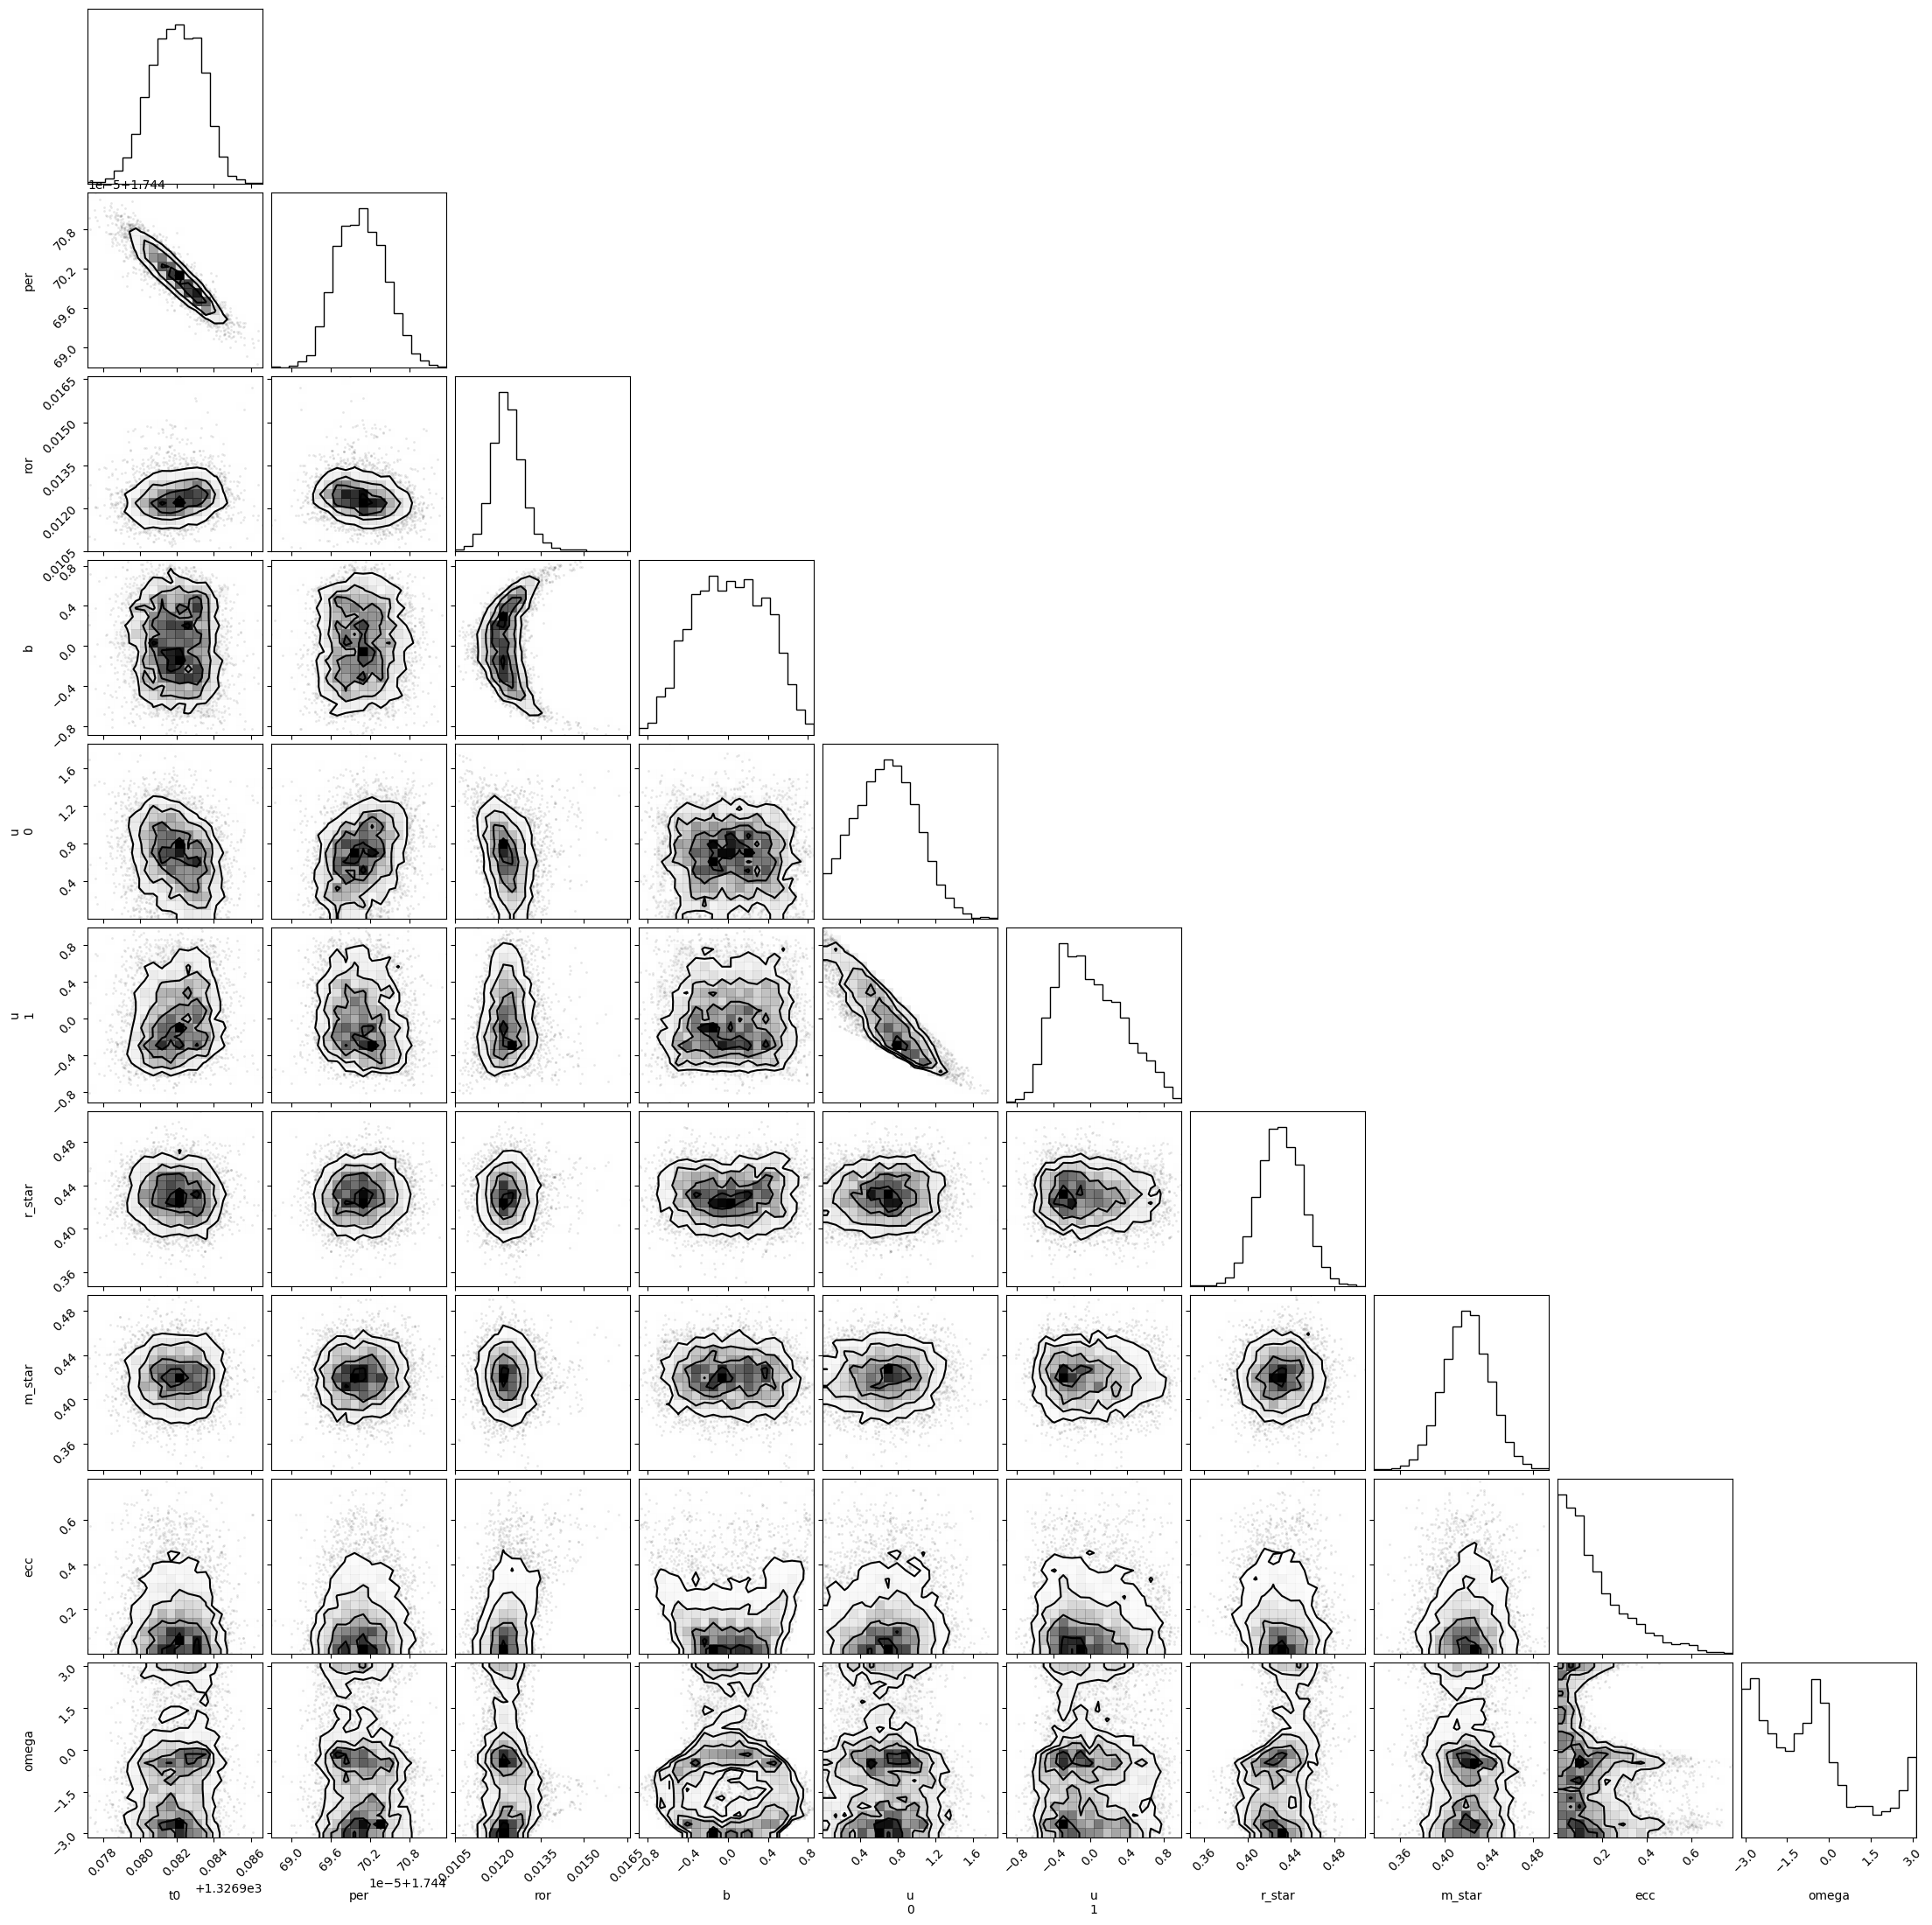

In [ ]:
_ = corner.corner(trace, var_names=sampled_params)

In [17]:
def get_rho(period, duration, depth, transit_shape):
    # following 1.14 from aude thesis
    G = 2942 # Rsun^3 / Msun / day^2, so return is in solar densities
    # this has some assumptions so i should check them
    return 32 * period * depth**0.75 / G / 3.14159 / duration**3 / (1 - transit_shape**2)**1.5

def get_transit_shape(ror, b):
    # Eq 1.4 from https://www.astro.ex.ac.uk/people/alapini/Publications/PhD_chap1.pdf
    return np.sqrt(((1 - ror) ** 2 - b ** 2) / ((1 + ror) ** 2 - b ** 2))

In [99]:
from util import (
    get_a,
    get_aor,
    get_inclination,
    get_radius,
    get_teq,
    get_insolation,
    get_duration,
    get_rho,
    get_transit_shape,
    print_stats,
)

In [25]:
samples = trace.posterior.stack(sample=("chain", "draw"))

In [100]:
ignore_params = ["full_lc", "lcs", "ecs", "mean", "u"]
sampled_params = ["t0", "per", "ror", "b", "u0", "u1", "r_star", "m_star", "ecc", "omega"]

samples["u0"] = samples["u"][0]
samples["u1"] = samples["u"][1]

# Values from Table 1. Averaged stds.
teff_data = samples["per"].copy()
teff_data.data = np.random.normal(3485, 138.5, len(samples["t0"]))
samples["teff"] = teff_data

samples["a"] = get_a(samples["per"], samples["m_star"])
samples["depth"] = samples["ror"]**2
samples["aor"] = get_aor(samples["per"], samples["r_star"], samples["m_star"])
samples["inc"] = get_inclination(samples["per"], samples["b"], samples["r_star"], samples["m_star"])
samples["r_p"] = get_radius(samples["ror"], samples["r_star"])
samples["teq"] = get_teq(samples["per"], samples["r_star"], samples["teff"], samples["m_star"])
samples["irr"] = get_insolation(samples["per"], samples["r_star"], samples["teff"], samples["m_star"])
samples["dur"] = get_duration(samples["per"], samples["ror"], samples["b"], samples["r_star"], samples["m_star"])
samples["tf/tt"] = get_transit_shape(samples["ror"], samples["b"])
samples["qin"] = (1 - samples["tf/tt"]) / 2
samples["rho"] = get_rho(samples["per"], samples["dur"], samples["depth"], samples["tf/tt"])

derived_params = list(samples.keys() - set(sampled_params) - set(ignore_params))
print("Sampled:", sampled_params)
print("Derived:", derived_params)

Sampled: ['t0', 'per', 'ror', 'b', 'u0', 'u1', 'r_star', 'm_star', 'ecc', 'omega']
Derived: ['dur', 'inc', 'irr', 'rho', 'a', 'qin', 'depth', 'tf/tt', 'teq', 'aor', 'r_p']


In [102]:
print("Sampled:")
for param_name in sampled_params:
    match param_name:
        case "b": print_stats("|b|", get_stats(np.abs(samples[param_name])))
        case _: print_stats(param_name, get_stats(samples[param_name], sigma=1))
print()

print("Derived:")
for param_name in derived_params:
    print_stats(param_name, get_stats(samples[param_name], sigma=1))

Sampled:
t0        1326.98199 [  -0.00025,    0.00026]
per       1.74470063 [-0.00000072, 0.00000067]
ror         0.012304 [ -0.000082,   0.000088]
|b|            0.279 [    -0.039,      0.041]
u0             0.684 [    -0.064,      0.058]
u1            -0.046 [    -0.064,      0.076]
r_star        0.4303 [   -0.0035,     0.0037]
m_star        0.4205 [   -0.0036,     0.0034]
ecc            0.124 [    -0.018,      0.028]
omega          -0.91 [     -0.37,       0.24]

Derived:
dur            1.209 [    -0.017,      0.013]
inc            89.91 [     -0.39,       0.39]
irr             54.5 [      -1.8,        1.9]
rho        0.0003789 [-0.0000091,  0.0000098]
a           0.021249 [ -0.000061,   0.000058]
qin          0.01310 [  -0.00025,    0.00051]
depth      0.0001514 [-0.0000020,  0.0000022]
tf/tt        0.97380 [  -0.00102,    0.00050]
teq            756.2 [      -6.4,        6.3]
aor           10.611 [    -0.086,      0.090]
r_p           0.5768 [   -0.0061,     0.0065]


In [ ]:
# Old stuff below

ror [158.4 118.3 317.7]

shp 1 [0.967 0.953 0.973]
shp 2 [0.967 0.8   0.977]
shp 3 [0.967 0.544 0.978]

qin 1 [0.017 0.013 0.024]
qin 2 [0.017 0.012 0.1  ]
qin 3 [0.017 0.011 0.228]

rho [3.516 0.092 6.738]

dmag 1 [0.7 0.3 1.3]
dmag 2 [0.7 0.  4.2]
dmag 3 [0.7 0.  6.4]


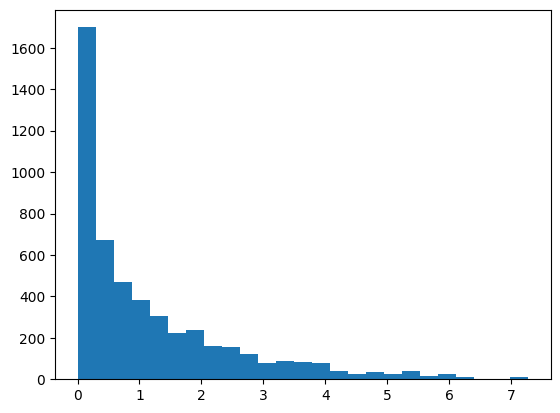

In [23]:
transit_shape_samples = get_transit_shape(samples["ror"], samples["b"])
rho_samples = get_rho(samples["per"], samples["dur"], samples["ror"]**2, transit_shape_samples)

d_blend_samples = (1 - transit_shape_samples)**2 / (1 + transit_shape_samples)**2
d_blend_samples = (1 - transit_shape_samples)**2 / (1 + transit_shape_samples)**2
d_obs_samples = samples["ror"]**2

# treat tmag as total mag
f = d_obs_samples / d_blend_samples
dmag_samples = - 2.5 * np.log10(f)
plt.hist(dmag_samples, bins=25)

print("ror", np.round(get_stats(samples["ror"]**2*10**6, sigma=3), 1))
print()

print("shp 1", np.round(get_stats(transit_shape_samples, sigma=1), 3))
print("shp 2", np.round(get_stats(transit_shape_samples, sigma=2), 3))
print("shp 3", np.round(get_stats(transit_shape_samples, sigma=3), 3))
print()

print("qin 1", np.round(get_stats((1-transit_shape_samples)/2, sigma=1), 3))
print("qin 2", np.round(get_stats((1-transit_shape_samples)/2, sigma=2), 3))
print("qin 3", np.round(get_stats((1-transit_shape_samples)/2, sigma=3), 3))
print()

print("rho", np.round(get_stats(rho_samples, sigma=3), 3))
print()

print("dmag 1", np.round(get_stats(dmag_samples, sigma=1), 1))
print("dmag 2", np.round(get_stats(dmag_samples, sigma=2), 1))
print("dmag 3", np.round(get_stats(dmag_samples, sigma=3), 1))


In [20]:
median_lc = np.nanmedian(samples["full_lc"], axis=1)
median_per = np.nanmedian(samples["per"])
median_t0 = np.nanmedian(samples["t0"])

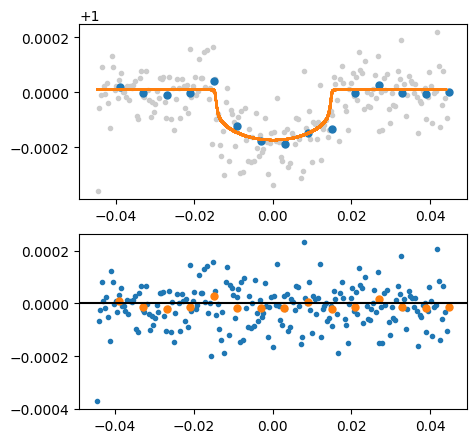

In [21]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plot_binned(lc["time"], lc["flux"], median_per, median_t0, bins=int(period/(1/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], median_per, median_t0, bins=int(period/(15/60/24)), s=100)
plot_binned(lc["time"], median_lc, median_per, median_t0, s=1)

plt.subplot(2, 1, 2)
plot_binned(lc["time"], lc["flux"] - median_lc, median_per, median_t0, bins=int(period/(1/60/24)))
plot_binned(lc["time"], lc["flux"] - median_lc, median_per, median_t0, bins=int(period/(15/60/24)), s=100)
plt.axhline(0, color="k")